# Generate ROC curve for Sketch Filter

## Load Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import time

In [1]:
problem_regions = set([
    "chr8_25402079-25402692.npy",
    "chr8_25400686-25401414.npy",
    "chr18_14614837-14615417.npy",
    "chr4_135051533-135052045.npy",
    "chr15_27348617-27349198.npy",
    "chr7_1142401-1144866.npy",
    "chr7_151782043-151782443.npy",
    "chr12_8402962-8403388.npy",
    "chr1_37640513-37642567.npy",
    "chr16_84401461-84401863.npy",
    "chr20_34665376-34666969.npy"
])

In [3]:
NUM_HASHES = 1000

class charMtxs():
    def __init__(self):
        self.char_mtxs = []

    """
    Load into memory all characteristic matrices
    """
    def load(self, directory, local_problem_regions = problem_regions):
        for file in os.listdir(directory):
            if file in local_problem_regions: continue
            self.char_mtxs.append(
                np.load( os.path.join(directory,file) )
            )
    
    """
    Use banding technique to bin reads by similarity
    """
    def band(self, band_length):
        counts = [0 for _ in range(4)]
        for matrix in self.char_mtxs:
            labels = matrix[0,:].astype('int8')
            characteristic_matrix = matrix[1:,:]
            for i, count in enumerate(
                self.tprCharacteristicMatrix(characteristic_matrix, band_length, labels)
            ):
                counts[i] += count
        return counts

    """
    Generate TPR and FPR for a given characteristic matrix, band length, and label list
    Returns [test_pos, tot_pos, test_neg, tot_neg]
    """
    def tprCharacteristicMatrix(self, characteristic_matrix, band_length, labels):
        #test_pos, tot_pos, test_neg, tot_neg
        counts = [0 for _ in range(4)]
        label_change = np.argmax(labels>1)

        def bucketTPRFPR(bucket, local_label_change = label_change):
            local_counts = [0, 0]
            num_label_a = 0
            num_label_b = 0
            for i in range(len(bucket)):
                if bucket[i] < local_label_change:
                    num_label_a += 1
                else:
                    num_label_b += 1
            local_counts[0] = int(num_label_a * (num_label_a - 1) / 2) # Number of edges in complete graph
            local_counts[1] = int(num_label_a * num_label_b)# Number of edges in complete bipartite graph
            return local_counts

        num_bands = NUM_HASHES//band_length
        for i in range(num_bands):
            buckets = defaultdict(list[int])
            startBucket = i*band_length
            endBucket = (i+1)*band_length
            for j in range(len(labels)):
                buckets[characteristic_matrix[startBucket:endBucket, j].tobytes()].append(j)
            for bucket in buckets.values():
                test_pos, test_neg = bucketTPRFPR(bucket)
                counts[0] += test_pos
                counts[2] += test_neg
        
        counts[1] = int(num_bands * (
            (label_change * (label_change - 1) / 2) + 
            ((len(labels)-label_change) * (len(labels)-label_change - 1)/ 2)
        ))
        counts[3] = int(num_bands * (label_change * (len(labels)-label_change)))

        return counts


In [5]:
def loadSketch():
    sketch_dir = "/data/wford/sv_merge/output/charMtxs/sketch/1000,20,40"
    sketch_test = charMtxs()
    start_time = time.time()
    sketch_test.load(sketch_dir)
    load_time = time.time()
    print("Load Time:", load_time - start_time)
    return sketch_test

def runTest(sketch_test, band_size):
    start_time = time.time()
    output = sketch_test.band(band_size)
    band_time = time.time()
    print("Band Time:", band_time - start_time)
    return output

## Generate ROC curve

In [6]:
sketch_outputs = []
sketch_bands = []
sketch_test = loadSketch()
for i in range(1, 200, 2):
    sketch_bands.append(i)
    output = runTest(sketch_test, i)
    sketch_outputs.append(output)

Load Time: 1.6616930961608887
Band Time: 108.79039573669434
Band Time: 50.41018557548523
Band Time: 33.41700100898743
Band Time: 26.606045961380005
Band Time: 22.106889724731445
Band Time: 19.157289028167725
Band Time: 17.162254571914673
Band Time: 15.638566255569458
Band Time: 14.24834680557251
Band Time: 13.21318244934082
Band Time: 12.336097478866577
Band Time: 11.594231843948364
Band Time: 11.12865400314331
Band Time: 10.500617742538452
Band Time: 9.75747013092041
Band Time: 9.52225399017334
Band Time: 8.999494314193726
Band Time: 8.549122095108032
Band Time: 8.300074815750122
Band Time: 7.618449449539185
Band Time: 7.41457724571228
Band Time: 7.237011194229126
Band Time: 6.992138385772705
Band Time: 6.78967022895813
Band Time: 6.522345066070557
Band Time: 6.288733720779419
Band Time: 6.03843092918396
Band Time: 7.148625135421753
Band Time: 5.863368272781372
Band Time: 5.55020546913147
Band Time: 5.716521739959717
Band Time: 5.432544469833374
Band Time: 5.964444160461426
Band Time:

In [10]:
sketch_tprs = []
sketch_fprs = []
for a, b, c, d in sketch_outputs:
    sketch_tprs.append(a/b)
    sketch_fprs .append(c/d)

In [17]:
"""
Calculate area under curve using middle estimate Riemann sum.
"""
def auc(fprs, tprs):
    n = len(tprs)
    area = 0
    for i in range(1, n):
        area += (fprs[i]-fprs[i-1])*((tprs[i]+tprs[i-1])/2)
    return area

"""
Plot the ROC curve with area under curve labeled.
"""
def plotROC(tprs, fprs, sketch_bands, title = "ROC Curve"):
    roc_auc = auc(fprs, tprs)
    # Plot the ROC curv e
    plt.figure()  
    plt.plot(fprs, tprs,label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

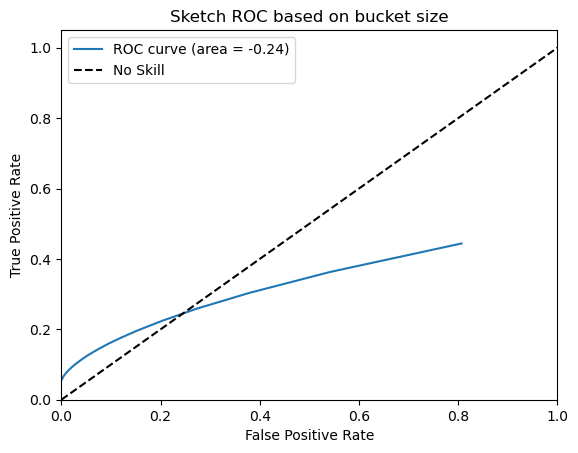

In [18]:
title = "Sketch ROC based on bucket size"
plotROC(sketch_tprs, sketch_fprs, sketch_bands, title)